# Data Analysis: E-commerce Data Analysis 

Data Analysis in e-commerce involves gathering and examining data from diverse online retail sources to discover patterns in pricing, product ratings, and inventory management. By scraping product details: such as price changes, discounts, and stock levels from multiple websites and feeds, analysts can identify trends like seasonal pricing fluctuations, best-selling products, and customer satisfaction levels reflected in ratings. This multi-source approach provides a richer, more accurate understanding of market behavior, helping businesses set competitive prices, forecast demand, optimize stock, and improve customer experience. Ultimately, it turns raw, scattered online data into actionable insights for strategic decision-making in the digital marketplace.

## A. Multi Source Data Collection

### Install libraries for Web Scraping and Data Gathering

In [1]:
#pip install pandas

In [2]:
#pip install lxml

In [3]:
#pip install beautifulsoup4

In [4]:
#pip install jupyterlab requests


In [5]:
#pip install feedparser

In [6]:
import logging
import time
import random
from typing import List, Dict, Optional
from urllib.parse import urljoin

import requests
from bs4 import BeautifulSoup
import pandas as pd
import feedparser
import re
from pathlib import Path
import pandas as json

1. Scraping of Book Data

- A) LOGGING & HTTP HELPERS

In [7]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

def get_html(url, timeout=15): #define a function to get web pages
    try:
        r = requests.get(url, timeout=timeout, headers={"User-Agent":"Mozilla/5.0 (edu-scraper)"}) #define the http request 
        r.raise_for_status() #checking http status code
        return r.text #return the web page as a string
    except requests.RequestException as e: #Handling of errors gracefully
        logging.warning(f"Request failed: {e}")
        return None


- B) SCRAPER 1: Books to Scrape (All pg)

In [8]:
BASE = "http://books.toscrape.com/"

html = get_html(BASE)
soup = BeautifulSoup(html, "lxml")

# grab the first page’s book tiles
products = soup.select("article.product_pod")
len(products), products[0].prettify()[:500]

(20,
 '<article class="product_pod">\n <div class="image_container">\n  <a href="catalogue/a-light-in-the-attic_1000/index.html">\n   <img alt="A Light in the Attic" class="thumbnail" src="media/cache/2c/da/2cdad67c44b002e7ead0cc35693c0e8b.jpg"/>\n  </a>\n </div>\n <p class="star-rating Three">\n  <i class="icon-star">\n  </i>\n  <i class="icon-star">\n  </i>\n  <i class="icon-star">\n  </i>\n  <i class="icon-star">\n  </i>\n  <i class="icon-star">\n  </i>\n </p>\n <h3>\n  <a href="catalogue/a-light-in-the-attic_1000/ind')

- C) Extract fields from tiles

In [9]:
def rating_from_class(classes):
    mapping = {"One":1,"Two":2,"Three":3,"Four":4,"Five":5}
    for c in classes or []:
        if c in mapping: return mapping[c]
    return None

def parse_price(text):
    # Remove both £ and Â characters before converting to float
    cleaned_text = text.replace("£", "").replace("Â", "").strip()
    return float(cleaned_text)

rows = []
for art in products:
    title = art.h3.a["title"]
    rel = art.h3.a["href"]
    product_url = BASE + rel.replace("../","")
    price = parse_price(art.select_one(".price_color").get_text())
    rating = rating_from_class(art.select_one("p.star-rating")["class"])
    availability = art.select_one(".availability").get_text(strip=True)
    rows.append({"title":title, "price":price, "rating":rating, "availability":availability, "product_url":product_url})

rows[:3]



[{'title': 'A Light in the Attic',
  'price': 51.77,
  'rating': 3,
  'availability': 'In stock',
  'product_url': 'http://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html'},
 {'title': 'Tipping the Velvet',
  'price': 53.74,
  'rating': 1,
  'availability': 'In stock',
  'product_url': 'http://books.toscrape.com/catalogue/tipping-the-velvet_999/index.html'},
 {'title': 'Soumission',
  'price': 50.1,
  'rating': 1,
  'availability': 'In stock',
  'product_url': 'http://books.toscrape.com/catalogue/soumission_998/index.html'}]

- D) Loop categories and finding Next Page Link

In [11]:
from bs4 import BeautifulSoup
all_rows = []

for cat_url in category_urls[:2]:  # start with just first 2 categories to test
    page_url = cat_url
    while page_url:
        html = get_html(page_url)
        if not html: break
        page = BeautifulSoup(html, "lxml")
        # extract products from this page
        for art in page.select("article.product_pod"):
            title = art.h3.a["title"]
            rel = art.h3.a["href"]
            product_url = BASE + "catalogue/" + rel.replace("../","")
            price = parse_price(art.select_one(".price_color").get_text())
            rating = rating_from_class(art.select_one("p.star-rating")["class"])
            availability = art.select_one(".availability").get_text(strip=True)
            all_rows.append({"title":title,"price":price,"rating":rating,"availability":availability,"product_url":product_url})

        # find next page link
        nxt = page.select_one("li.next a")
        if nxt:
            # build next URL relative to current
            if "/index.html" in page_url:
                base_page = page_url.rsplit("/",1)[0] + "/"
            else:
                base_page = page_url if page_url.endswith("/") else page_url.rsplit("/",1)[0] + "/"
            page_url = base_page + nxt["href"]
        else:
            page_url = None

len(all_rows), all_rows[:2]


(1011,
 [{'title': 'A Light in the Attic',
   'price': 51.77,
   'rating': 3,
   'availability': 'In stock',
   'product_url': 'http://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html'},
  {'title': 'Tipping the Velvet',
   'price': 53.74,
   'rating': 1,
   'availability': 'In stock',
   'product_url': 'http://books.toscrape.com/catalogue/tipping-the-velvet_999/index.html'}])

- E) Pagination Handling

In [10]:
# find all category links 
cat_links = [a.get("href") for a in soup.select(".side_categories a") if a.get("href")]
category_urls = [BASE + href for href in cat_links if "catalogue/category" in href]
category_urls[:5], len(category_urls)

(['http://books.toscrape.com/catalogue/category/books_1/index.html',
  'http://books.toscrape.com/catalogue/category/books/travel_2/index.html',
  'http://books.toscrape.com/catalogue/category/books/mystery_3/index.html',
  'http://books.toscrape.com/catalogue/category/books/historical-fiction_4/index.html',
  'http://books.toscrape.com/catalogue/category/books/sequential-art_5/index.html'],
 51)

- F) Data Fields and Formats for output

In [13]:
RAW_DIR = Path(r"C:\Users\NSBMIT\Documents\MSc\Data Analysis E Commerce Data Analysis\data collection"); RAW_DIR.mkdir(parents=True, exist_ok=True)

df_books = pd.DataFrame(all_rows)
df_books.to_csv(RAW_DIR / "books.csv", index=False)
df_books.to_json(RAW_DIR / "books.json", orient="records", indent=2)
df_books.head()


,title,price,rating,availability,product_url
0,A Light in the Attic,51.77,3,In stock,http://books.toscrape.com/catalogue/a-light-in...
1,Tipping the Velvet,53.74,1,In stock,http://books.toscrape.com/catalogue/tipping-th...
2,Soumission,50.10,1,In stock,http://books.toscrape.com/catalogue/soumission...
3,Sharp Objects,47.82,4,In stock,http://books.toscrape.com/catalogue/sharp-obje...
4,Sapiens: A Brief History of Humankind,54.23,5,In stock,http://books.toscrape.com/catalogue/sapiens-a-...


- G) Retry and Error Handling

In [14]:
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

def make_session():
    s = requests.Session()
    s.headers.update({"User-Agent":"Mozilla/5.0 (edu-scraper)"})
    retry = Retry(
        total=5, backoff_factor=0.5,
        status_forcelist=[429,500,502,503,504],
        allowed_methods=["GET","HEAD"]
    )
    adapter = HTTPAdapter(max_retries=retry)
    s.mount("http://", adapter); s.mount("https://", adapter)
    return s

def polite_get(session, url, timeout=15, min_s=0.8, max_s=1.8):
    try:
        r = session.get(url, timeout=timeout)
        r.raise_for_status()
        time.sleep(random.uniform(min_s, max_s))  # be polite
        return r.text
    except requests.RequestException as e:
        logging.warning(f"Fetch failed for {url}: {e}")
        return None

session = make_session()


In [15]:
def scrape_books(session, limit_categories=2):
    html = polite_get(session, BASE)
    soup = BeautifulSoup(html, "lxml")
    cat_links = [a.get("href") for a in soup.select(".side_categories a") if a.get("href")]
    category_urls = [BASE + href for href in cat_links if "catalogue/category" in href]
    if limit_categories: category_urls = category_urls[:limit_categories]

    rows = []
    for cat_url in category_urls:
        page_url = cat_url
        while page_url:
            page_html = polite_get(session, page_url)
            if not page_html: break
            page = BeautifulSoup(page_html, "lxml")
            for art in page.select("article.product_pod"):
                title = art.h3.a["title"]
                rel = art.h3.a["href"]
                product_url = BASE + "catalogue/" + rel.replace("../","")
                price = parse_price(art.select_one(".price_color").get_text())
                rating = rating_from_class(art.select_one("p.star-rating")["class"])
                availability = art.select_one(".availability").get_text(strip=True)
                rows.append({"title":title,"price":price,"rating":rating,"availability":availability,"product_url":product_url})
            nxt = page.select_one("li.next a")
            if nxt:
                if "/index.html" in page_url:
                    base_page = page_url.rsplit("/",1)[0] + "/"
                else:
                    base_page = page_url if page_url.endswith("/") else page_url.rsplit("/",1)[0] + "/"
                page_url = base_page + nxt["href"]
            else:
                page_url = None
    return rows

rows = scrape_books(session, limit_categories=2)
len(rows)


1011

2. Scrape a second demo e-commerce site

In [16]:
DEMO_ROOT = "https://webscraper.io/test-sites/e-commerce/static"

def parse_price_generic(text):
    import re
    m = re.search(r"([\d.,]+)", text)
    return float(m.group(1).replace(",","")) if m else None

def scrape_demo(session):
    out = []
    root = polite_get(session, DEMO_ROOT)
    soup = BeautifulSoup(root, "lxml")

    cats = [(a.get_text(strip=True), a.get("href")) for a in soup.select(".category-link")]
    for cat_name, href in cats:
        cat_url = DEMO_ROOT if href == "#" else "https://webscraper.io" + href
        cat_html = polite_get(session, cat_url)
        if not cat_html: continue
        cat_soup = BeautifulSoup(cat_html, "lxml")
        subs = [(a.get_text(strip=True), "https://webscraper.io" + a.get("href")) for a in cat_soup.select(".subcategory-link")]
        if not subs:
            subs = [(cat_name, cat_url)]
        for sub_name, sub_url in subs:
            sub_html = polite_get(session, sub_url)
            if not sub_html: continue
            sub_soup = BeautifulSoup(sub_html, "lxml")
            for card in sub_soup.select(".thumbnail"):
                title_el = card.select_one(".title")
                price_el = card.select_one(".price")
                rating_el = card.select_one(".ratings p[data-rating]")
                out.append({
                    "title": title_el.get_text(strip=True),
                    "price": parse_price_generic(price_el.get_text(strip=True)),
                    "rating": int(rating_el["data-rating"]) if rating_el and rating_el.has_attr("data-rating") else None,
                    "category": cat_name,
                    "subcategory": sub_name,
                    "product_url": "https://webscraper.io" + title_el["href"]
                })
    return out

demo_rows = scrape_demo(session)
len(demo_rows), demo_rows[:2]


(18,
 [{'title': 'Packard 255 G2',
   'price': 416.99,
   'rating': 2,
   'category': 'Computers',
   'subcategory': 'Laptops',
   'product_url': 'https://webscraper.io/test-sites/e-commerce/static/product/31'},
  {'title': 'Aspire E1-510',
   'price': 306.99,
   'rating': 3,
   'category': 'Computers',
   'subcategory': 'Laptops',
   'product_url': 'https://webscraper.io/test-sites/e-commerce/static/product/32'}])

- Data Fields and Output

In [20]:
import pandas as pd, json
demo_df = pd.DataFrame(demo_rows)
demo_df.to_csv(RAW_DIR / "demo_ecom.csv", index=False)
demo_df.to_json(RAW_DIR / "demo_ecom.json", orient="records", indent=2)
demo_df.head()


,title,price,rating,category,subcategory,product_url
0,Packard 255 G2,416.99,2,Computers,Laptops,https://webscraper.io/test-sites/e-commerce/st...
1,Aspire E1-510,306.99,3,Computers,Laptops,https://webscraper.io/test-sites/e-commerce/st...
2,ThinkPad T540p,1178.99,1,Computers,Laptops,https://webscraper.io/test-sites/e-commerce/st...
3,ProBook,739.99,4,Computers,Laptops,https://webscraper.io/test-sites/e-commerce/st...
4,ThinkPad X240,1311.99,3,Computers,Laptops,https://webscraper.io/test-sites/e-commerce/st...


3. Web Scraping Workflow – Structured Data from RSS Feeds

In [21]:
RSS_FEEDS = [
    "https://news.ycombinator.com/rss",
    "https://planetpython.org/rss20.xml"
]

def parse_rss(session, feeds):
    items = []
    for url in feeds:
        txt = polite_get(session, url)
        if not txt: continue
        feed = BeautifulSoup(txt, "xml")
        for item in feed.find_all("item"):
            items.append({
                "feed_url": url,
                "title": item.title.text if item.title else "",
                "link": item.link.text if item.link else "",
                "pub_date": item.pubDate.text if item.pubDate else None,
                "category": item.category.text if item.category else None
            })
    return items

rss_rows = parse_rss(session, RSS_FEEDS)
import pandas as pd
rss_df = pd.DataFrame(rss_rows)
rss_df.to_csv(RAW_DIR / "rss_items.csv", index=False)
rss_df.to_json(RAW_DIR / "rss_items.json", orient = "records", index=2)
rss_df.head()


,feed_url,title,link,pub_date,category
0,https://news.ycombinator.com/rss,ChatControl: EU wants to scan all private mess...,https://metalhearf.fr/posts/chatcontrol-wants-...,"Thu, 25 Sep 2025 16:01:41 +0000",None
1,https://news.ycombinator.com/rss,ChatGPT Pulse,https://openai.com/index/introducing-chatgpt-p...,"Thu, 25 Sep 2025 16:59:55 +0000",None
2,https://news.ycombinator.com/rss,Brutalita Sans: An Experimental Font and Font ...,https://brutalita.com/,"Tue, 23 Sep 2025 13:54:10 +0000",None
3,https://news.ycombinator.com/rss,Improved Gemini 2.5 Flash and Flash-Lite,https://developers.googleblog.com/en/continuin...,"Thu, 25 Sep 2025 17:20:56 +0000",None
4,https://news.ycombinator.com/rss,The Harvard-Emory ECG Database,https://bdsp.io/content/heedb/4.0/,"Thu, 25 Sep 2025 16:31:02 +0000",None


4. Extracting numerical and categorical data for analysis

In [22]:
import pandas as pd
books = pd.read_csv(RAW_DIR / "books.csv")
demo  = pd.read_csv(RAW_DIR / "demo_ecom.csv")

# Convert numeric safely
books["price"] = pd.to_numeric(books["price"], errors="coerce")
books["rating"] = pd.to_numeric(books["rating"], errors="coerce")
demo["price"]  = pd.to_numeric(demo["price"], errors="coerce")
demo["rating"] = pd.to_numeric(demo["rating"], errors="coerce")

# Inventory flag (books)
books["in_stock"] = books["availability"].str.contains("In stock", case=False, na=False)

print("Books — price summary:")
display(books["price"].describe().round(2))

print("Books — avg price by category:")
display(books.groupby("product_url".replace("product_url","category") if "category" in books.columns else "availability")["price"].mean().head(3))  # harmless demo

print("Demo — price summary:")
display(demo["price"].describe().round(2))

print("Ratings (books then demo):")
display(books["rating"].value_counts().sort_index())
display(demo["rating"].value_counts().sort_index())


Books — price summary:


count    1011.00
mean       35.12
std        14.41
min        10.00
25%        22.13
50%        36.17
75%        47.47
max        59.99
Name: price, dtype: float64

Books — avg price by category:


availability
In stock    35.121751
Name: price, dtype: float64

Demo — price summary:


count      18.00
mean      357.99
std       389.65
min        24.99
25%        94.74
50%       114.49
75%       528.49
max      1311.99
Name: price, dtype: float64

Ratings (books then demo):


rating
1    228
2    199
3    206
4    181
5    197
Name: count, dtype: int64

rating
1    5
2    2
3    6
4    5
Name: count, dtype: int64

## B. Data Cleaning and Preprocessing - Pipeline

Text preprocessing (remove special characters, normalize text)

In [30]:

# simple_pipeline.py
import re
import unicodedata
from datetime import timezone
from typing import List, Dict, Tuple, Optional

import pandas as pd
import numpy as np

# -----------------------------
# 1) Text preprocessing helpers
# -----------------------------
URL_RE     = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
EMAIL_RE   = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w{2,}\b", re.IGNORECASE)
HASHTAG_RE = re.compile(r"(?<!\w)#(\w+)")
MENTION_RE = re.compile(r"(?<!\w)@(\w+)")
NONWORD_RE = re.compile(r"[^\w\s]")             # keep letters/digits/_ + spaces
MULTI_WS   = re.compile(r"\s+")

STOPWORDS = {
    "a","an","and","the","to","is","are","of","for","in","on","at","by",
    "it","from","as","that","this","with","or","be","we","you","your"
}

def _strip_accents(text: str) -> str:
    # café -> cafe
    nfkd = unicodedata.normalize("NFKD", text)
    return "".join(ch for ch in nfkd if not unicodedata.combining(ch))

def _remove_emojis(text: str) -> str:
    # remove most emoji/symbol codepoints
    return "".join(ch for ch in text if unicodedata.category(ch) not in {"So","Sk","Sm"})

def clean_text(text: Optional[str]) -> str:
    """Normalize unicode, lowercase, remove URLs/emails/emojis/punct, collapse spaces."""
    if not text:
        return ""
    t = unicodedata.normalize("NFKC", text).lower()
    t = URL_RE.sub(" ", t)
    t = EMAIL_RE.sub(" ", t)
    t = _remove_emojis(t)
    t = NONWORD_RE.sub(" ", t)
    t = _strip_accents(t)
    t = MULTI_WS.sub(" ", t).strip()
    return t

def extract_hashtags_mentions(raw_text: str) -> Tuple[List[str], List[str]]:
    return HASHTAG_RE.findall(raw_text or ""), MENTION_RE.findall(raw_text or "")

def simple_keywords(tokens: List[str], top_k: int = 8) -> List[str]:
    freq: Dict[str, int] = {}
    for w in tokens:
        if not w or w in STOPWORDS or w.isdigit() or len(w) <= 2:
            continue
        freq[w] = freq.get(w, 0) + 1
    return [w for w, _ in sorted(freq.items(), key=lambda x: (-x[1], x[0]))[:top_k]]


Handle missing data and duplicates

In [31]:
# -----------------------------------
# 2) Missing data & duplicate handling
# -----------------------------------
def nanify_empty_strings(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in out.select_dtypes(include=["object", "string"]).columns:
        out[c] = out[c].apply(lambda x: np.nan if isinstance(x, str) and x.strip() == "" else x)
    return out

def drop_dupes(df: pd.DataFrame, key_cols: Optional[List[str]] = None) -> pd.DataFrame:
    out = df.drop_duplicates() if key_cols is None else df.drop_duplicates(subset=key_cols, keep="first")
    return out

def impute_numeric(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce").fillna(out[c].median(skipna=True))
    return out

def impute_categorical(df: pd.DataFrame, cols: List[str], fill_value: str = "Unknown") -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        if c in out.columns:
            mode = out[c].mode(dropna=True)
            out[c] = out[c].fillna(mode.iloc[0] if not mode.empty else fill_value)
    return out



Extract hashtags, mentions, and keywords

In [32]:
# ------------------------------
# 3) Date/time standardization
# ------------------------------
def standardize_datetime(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    out = df.copy()
    if date_col in out.columns:
        out[date_col + "_utc"] = (
            pd.to_datetime(out[date_col], errors="coerce", utc=True)
            .dt.tz_convert("UTC")
        )
    return out

Date/time standardization across different sources

In [33]:
# ------------------------------
# 4) Validation & quick QA checks
# ------------------------------
def validate(df: pd.DataFrame, rules: Dict[str, Dict], dt_col_utc: Optional[str] = None) -> Dict:
    """
    rules example:
      {
        "id": {"required": True, "unique": True},
        "price": {"ge": 0},
        "rating": {"between": (0, 5)}
      }
    """
    rep: Dict[str, Dict] = {}
    for col, spec in rules.items():
        colrep = {"present": col in df.columns}
        if not colrep["present"]:
            rep[col] = colrep
            continue
        s = df[col]
        if spec.get("required"):
            colrep["missing"] = int(s.isna().sum())
        if spec.get("unique"):
            colrep["duplicates"] = int(s.duplicated().sum())
        if "ge" in spec:
            colrep["ge_viol"] = int((pd.to_numeric(s, errors="coerce").dropna() < spec["ge"]).sum())
        if "le" in spec:
            colrep["le_viol"] = int((pd.to_numeric(s, errors="coerce").dropna() > spec["le"]).sum())
        if "between" in spec:
            lo, hi = spec["between"]
            num = pd.to_numeric(s, errors="coerce").dropna()
            colrep["between_viol"] = int(((num < lo) | (num > hi)).sum())
        rep[col] = colrep

    if dt_col_utc and dt_col_utc in df.columns:
        now = pd.Timestamp.utcnow().tz_localize("UTC")
        rep[dt_col_utc] = {"future_timestamps": int((df[dt_col_utc].dropna() > now).sum())}
    return rep

Data Processing Pipeline

In [34]:
# ------------------------------
# 5) Pipeline (compose the steps)
# ------------------------------
def run_pipeline(
    df: pd.DataFrame,
    *,
    text_col: Optional[str] = "text",
    date_col: Optional[str] = "date",
    key_cols_for_dupes: Optional[List[str]] = None,
    numeric_impute_cols: Optional[List[str]] = None,
    categorical_impute_cols: Optional[List[str]] = None,
) -> Tuple[pd.DataFrame, Dict]:
    """
    Returns (cleaned_df, report)
    """
    rep: Dict = {}

    # Missing normalization
    df = nanify_empty_strings(df)

    # Duplicates
    before = len(df)
    df = drop_dupes(df, key_cols_for_dupes)
    rep["duplicates_dropped"] = before - len(df)

    # Text preprocess + features
    if text_col and text_col in df.columns:
        raw = df[text_col].fillna("")
        df["hashtags"] = raw.apply(lambda x: extract_hashtags_mentions(x)[0])
        df["mentions"] = raw.apply(lambda x: extract_hashtags_mentions(x)[1])
        df["text_clean"] = raw.apply(clean_text)
        df["tokens"] = df["text_clean"].str.split()
        df["keywords"] = df["tokens"].apply(simple_keywords)

    # Date standardization
    if date_col and date_col in df.columns:
        df = standardize_datetime(df, date_col)

    # Impute
    if numeric_impute_cols:
        df = impute_numeric(df, numeric_impute_cols)
    if categorical_impute_cols:
        df = impute_categorical(df, categorical_impute_cols)

    # Basic validation (edit to match your schema)
    rules = {}
    if "rating" in df.columns:
        rules["rating"] = {"between": (0, 5)}
    if "price" in df.columns:
        rules["price"] = {"ge": 0}

    dt_col_utc = f"{date_col}_utc" if date_col and f"{date_col}_utc" in df.columns else None
    rep["validation"] = validate(df, rules, dt_col_utc)

    # Quick stats you can paste in a report
    rep["missing_after_%"] = (df.isna().mean().round(4) * 100).to_dict()
    rep["shape"] = df.shape
    return df, rep

C. Advanced Statistical Analysis

In [40]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Load your combined CSV (example: books data)
df = pd.read_csv(r"C:\Users\NSBMIT\Documents\MSc\Data Analysis E Commerce Data Analysis\data collection\books.csv")

# Inspect the first rows
df.head()


,title,price,rating,availability,product_url
0,A Light in the Attic,51.77,3,In stock,http://books.toscrape.com/catalogue/a-light-in...
1,Tipping the Velvet,53.74,1,In stock,http://books.toscrape.com/catalogue/tipping-th...
2,Soumission,50.10,1,In stock,http://books.toscrape.com/catalogue/soumission...
3,Sharp Objects,47.82,4,In stock,http://books.toscrape.com/catalogue/sharp-obje...
4,Sapiens: A Brief History of Humankind,54.23,5,In stock,http://books.toscrape.com/catalogue/sapiens-a-...


In [41]:
desc_stats = df['price'].describe()   # count, mean, std, min, quartiles, max
median_price = df['price'].median()
mode_price = df['price'].mode()[0]

print(desc_stats)
print("Median:", median_price)
print("Mode:", mode_price)


count    1011.000000
mean       35.121751
std        14.413324
min        10.000000
25%        22.130000
50%        36.170000
75%        47.475000
max        59.990000
Name: price, dtype: float64
Median: 36.17
Mode: 16.28


In [44]:
print(df.columns)

Index(['title', 'price', 'rating', 'availability', 'product_url'], dtype='object')


INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


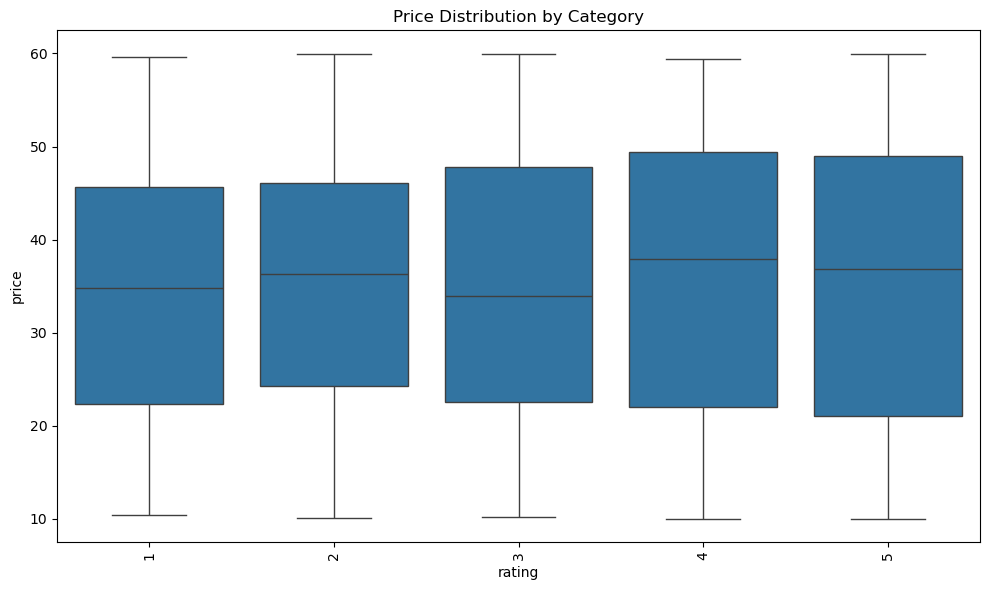

In [45]:
plt.figure(figsize=(10,6))
sns.boxplot(x='rating', y='price', data=df)
plt.xticks(rotation=90)
plt.title("Price Distribution by Rating")
plt.tight_layout()
plt.show()


In [46]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['price'] < Q1 - 1.5*IQR) | (df['price'] > Q3 + 1.5*IQR)]
print("Outliers count:", len(outliers))


Outliers count: 0


                     price    rating  availability_num
price             1.000000  0.029587               NaN
rating            0.029587  1.000000               NaN
availability_num       NaN       NaN               NaN


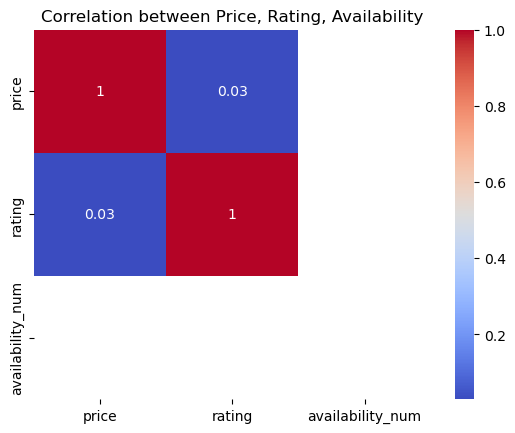

In [47]:
# example: availability string like 'In stock (22 available)'
df['availability_num'] = df['availability'].str.extract(r'(\d+)').astype(float)

# correlation matrix
corr = df[['price','rating','availability_num']].corr()
print(corr)

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation between Price, Rating, Availability")
plt.show()


rating
1    228
3    206
2    199
5    197
4    181
Name: count, dtype: int64


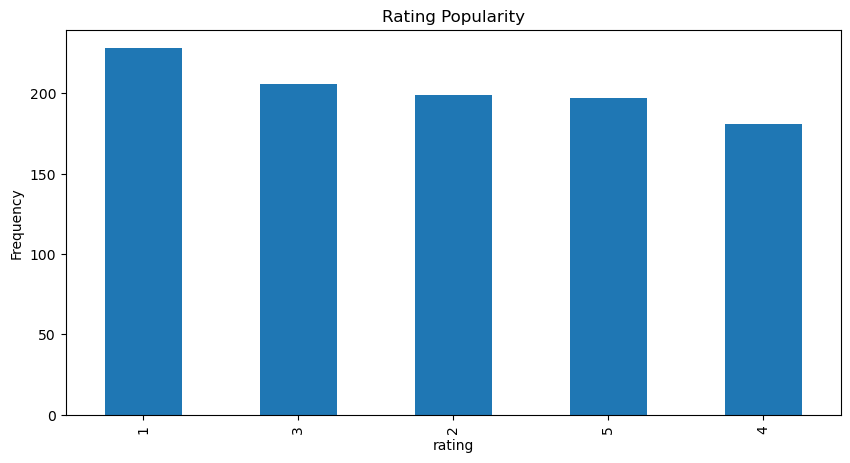

In [50]:
cat_freq = df['rating'].value_counts()
print(cat_freq)

cat_freq.plot(kind='bar', figsize=(10,5))
plt.title("Rating Popularity")
plt.ylabel("Frequency")
plt.show()


In [55]:
fiction = df[df['rating'].str.contains("Fiction", case=False)]['price']
non_fiction = df[~df['rating'].str.contains("Fiction", case=False)]['price']

t_stat, p_value = stats.ttest_ind(fiction, non_fiction, equal_var=False)
print("T-test statistic:", t_stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("Significant difference in mean prices (reject H0).")
else:
    print("No significant difference (fail to reject H0).")


AttributeError: Can only use .str accessor with string values!

D. Visualizations

In [59]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.io import write_html

# ------------------ Config ------------------
INPUT_CSV  = r"C:\Users\NSBMIT\Documents\MSc\Data Analysis E Commerce Data Analysis\data collection\books.csv"
OUTPUT_DIR = "./books_viz_outputs"
TOP_N      = 15   # limit categories for clearer plots
sns.set_theme(style="whitegrid")

# ------------------ Setup -------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load the Books dataset
df = pd.read_csv(INPUT_CSV)
print("Detected columns:", list(df.columns))
print(df.head())

# Ensure key numeric columns exist
def coerce_price(x):
    if pd.isna(x): return np.nan
    s = re.sub(r"[^\d.,-]", "", str(x))
    if "," in s and "." in s: s = s.replace(",", "")
    else: s = s.replace(",", ".")
    try: return float(s)
    except: return np.nan

def coerce_rating(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    words = {"one":1,"two":2,"three":3,"four":4,"five":5}
    if s in words: return words[s]
    m = re.search(r"(\d+(\.\d+)?)", s)
    return float(m.group(1)) if m else np.nan

def extract_avail(x):
    if pd.isna(x): return np.nan
    m = re.search(r"(\d+)", str(x))
    return float(m.group(1)) if m else np.nan

if "price_num" not in df.columns:
    df["price_num"] = df["price"].apply(coerce_price)
if "rating_num" not in df.columns:
    df["rating_num"] = df["rating"].apply(coerce_rating)
if "availability_num" not in df.columns:
    df["availability_num"] = df["availability"].apply(extract_avail)

# Detect optional columns
category_col = "category" if "category" in df.columns else None
source_col   = "source"   if "source"   in df.columns else None

# ------------------ Static Visuals ------------------

# Price distribution histograms and box plots by category
plt.figure(figsize=(10,6))
df["price_num"].dropna().plot(kind="hist", bins=30, alpha=0.8)
plt.xlabel("Price (£)"); plt.ylabel("Frequency")
plt.title("Books – Overall Price Distribution")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/price_hist_overall.png", dpi=150)
plt.close()

if category_col:
    top_cats = df[category_col].value_counts().head(TOP_N).index
    plt.figure(figsize=(12,6))
    sns.boxplot(data=df[df[category_col].isin(top_cats)],
                x=category_col, y="price_num")
    plt.xticks(rotation=90)
    plt.title("Books – Price Distribution by Category (Top N)")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/price_box_by_category.png", dpi=150)
    plt.close()

# Rating vs price scatter with trend line
if df["rating_num"].notna().sum() > 2:
    plt.figure(figsize=(10,6))
    sns.regplot(x="price_num", y="rating_num", data=df,
                scatter_kws={"alpha":0.5})
    plt.title("Books – Rating vs Price (with trend line)")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/scatter_rating_vs_price.png", dpi=150)
    plt.close()

# Category popularity & average ratings
if category_col:
    cat_counts = df[category_col].value_counts().head(TOP_N)
    plt.figure(figsize=(12,6))
    cat_counts.plot(kind="bar")
    plt.title("Books – Category Popularity (Top N)")
    plt.ylabel("Book Count")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/category_popularity.png", dpi=150)
    plt.close()

    if df["rating_num"].notna().sum() > 0:
        avg_rating = (df.groupby(category_col)["rating_num"]
                      .mean().sort_values(ascending=False).head(TOP_N))
        plt.figure(figsize=(12,6))
        avg_rating.plot(kind="bar", color="teal")
        plt.title("Books – Average Rating by Category (Top N)")
        plt.ylabel("Average Rating")
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/avg_rating_by_category.png", dpi=150)
        plt.close()

# Comparative analysis by data source
if source_col:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x=source_col, y="price_num")
    plt.title("Books – Price Distribution by Source")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/price_by_source.png", dpi=150)
    plt.close()

# ------------------ Interactive Plotly Report ------------------

figs = []

# Interactive price histogram
figs.append(px.histogram(df, x="price_num", nbins=30,
            title="Interactive Price Distribution", color=category_col))

# Interactive rating vs price scatter
if df["rating_num"].notna().sum() > 2:
    figs.append(px.scatter(df, x="price_num", y="rating_num",
            color=category_col, title="Interactive Rating vs Price"))

# Interactive category popularity
if category_col:
    cat_df = df[category_col].value_counts().head(TOP_N).reset_index()
    cat_df.columns=[category_col,"count"]
    figs.append(px.bar(cat_df, x=category_col, y="count",
            title="Interactive Category Popularity (Top N)"))

# Combine all interactive figures into one HTML
html_parts = [f"<h2>{f.layout.title.text}</h2>" + f.to_html(full_html=False, include_plotlyjs=False)
              for f in figs]
html_report = f"""
<html>
<head><meta charset="utf-8">
<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
<title>Books Visual Analysis Report</title></head>
<body>
<h1>Books to Scrape – Interactive Visual Analysis</h1>
{''.join(html_parts)}
</body>
</html>
"""
with open(f"{OUTPUT_DIR}/interactive_books_report.html","w",encoding="utf-8") as f:
    f.write(html_report)

print(f"\n All visualizations created in: {os.path.abspath(OUTPUT_DIR)}")


Detected columns: ['title', 'price', 'rating', 'availability', 'product_url']
                                   title  price  rating availability  \
0                   A Light in the Attic  51.77       3     In stock   
1                     Tipping the Velvet  53.74       1     In stock   
2                             Soumission  50.10       1     In stock   
3                          Sharp Objects  47.82       4     In stock   
4  Sapiens: A Brief History of Humankind  54.23       5     In stock   

                                         product_url  
0  http://books.toscrape.com/catalogue/a-light-in...  
1  http://books.toscrape.com/catalogue/tipping-th...  
2  http://books.toscrape.com/catalogue/soumission...  
3  http://books.toscrape.com/catalogue/sharp-obje...  
4  http://books.toscrape.com/catalogue/sapiens-a-...  

 All visualizations created in: C:\Users\NSBMIT\Documents\MSc\Data Analysis E Commerce Data Analysis\books_viz_outputs


E. Predictive Analysis

In [62]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# ---------------- CONFIG ----------------
INPUT_CSV  = r"C:\Users\NSBMIT\Documents\MSc\Data Analysis E Commerce Data Analysis\data collection\books.csv"
OUTPUT_DIR = "./predictive_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------- Load and Prepare Data ----------------
df = pd.read_csv(INPUT_CSV)
print("Columns detected:", list(df.columns))

def coerce_price(x):
    if pd.isna(x): return np.nan
    s = re.sub(r"[^\d.,-]", "", str(x))
    if "," in s and "." in s: s = s.replace(",", "")
    else: s = s.replace(",", ".")
    try: return float(s)
    except: return np.nan

def coerce_rating(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    mapping = {"one":1,"two":2,"three":3,"four":4,"five":5}
    if s in mapping: return mapping[s]
    m = re.search(r"(\d+(\.\d+)?)", s)
    return float(m.group(1)) if m else np.nan

def extract_avail(x):
    if pd.isna(x): return np.nan
    m = re.search(r"(\d+)", str(x))
    return float(m.group(1)) if m else np.nan

if "price_num" not in df.columns:
    df["price_num"] = df["price"].apply(coerce_price)
if "rating_num" not in df.columns:
    df["rating_num"] = df["rating"].apply(coerce_rating)
if "availability_num" not in df.columns:
    df["availability_num"] = df["availability"].apply(extract_avail)

category_col = "category" if "category" in df.columns else None

# Drop rows missing key numeric fields
df_model = df.dropna(subset=["price_num","rating_num"]).copy()

# =======================================================
# Simple Linear Regression: Predict price from rating
# =======================================================
if len(df_model) > 5:
    X = df_model[["rating_num"]].values
    y = df_model["price_num"].values
    model = LinearRegression()
    model.fit(X, y)
    df_model["predicted_price"] = model.predict(X)

    r2 = r2_score(y, df_model["predicted_price"])
    coef = model.coef_[0]
    intercept = model.intercept_

    print(f"Linear Regression: price ≈ {intercept:.2f} + {coef:.2f}*rating")
    print(f"R² = {r2:.3f}")

    # Scatter + regression line
    plt.figure(figsize=(8,6))
    sns.regplot(x="rating_num", y="price_num", data=df_model,
                scatter_kws={"alpha":0.5})
    plt.title(f"Price Prediction from Rating (R²={r2:.2f})")
    plt.xlabel("Rating"); plt.ylabel("Price (£)")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/linear_regression_price_vs_rating.png", dpi=150)
    plt.close()

    # Save predictions
    df_model.to_csv(f"{OUTPUT_DIR}/price_prediction_results.csv", index=False)

# =======================================================
# Category Pricing Patterns
# =======================================================
if category_col:
    cat_summary = (df.groupby(category_col)["price_num"]
                   .agg(["count","mean","median","std","min","max"])
                   .sort_values("mean", ascending=False))
    cat_summary.to_csv(f"{OUTPUT_DIR}/category_price_patterns.csv")

    plt.figure(figsize=(12,6))
    cat_summary["mean"].plot(kind="bar", color="skyblue")
    plt.title("Average Price by Category")
    plt.ylabel("Average Price (£)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/category_average_price.png", dpi=150)
    plt.close()

# =======================================================
# Basic Recommendation System (statistical similarity)
# =======================================================
# We recommend books with similar (standardized) rating and price.
rec_cols = ["rating_num","price_num"]
df_rec = df.dropna(subset=rec_cols).reset_index(drop=True)
if len(df_rec) > 5:
    scaler = StandardScaler()
    features = scaler.fit_transform(df_rec[rec_cols])

    sim_matrix = cosine_similarity(features)
    rec_index = np.random.randint(0, len(df_rec))  # pick a random book to demo
    rec_scores = sim_matrix[rec_index]
    top_idx = np.argsort(rec_scores)[::-1][1:6]  # top 5 similar
    recommendations = df_rec.iloc[top_idx][["title","price","rating"]]
    recommendations.to_csv(f"{OUTPUT_DIR}/sample_recommendations.csv", index=False)

    print(f"\nSample recommendations for: {df_rec.loc[rec_index,'title']}")
    print(recommendations)

# =======================================================
# Trend Analysis: Stock availability vs price
# =======================================================
if df["availability_num"].notna().sum() > 5:
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df, x="availability_num", y="price_num", alpha=0.6)
    sns.regplot(data=df, x="availability_num", y="price_num", scatter=False,
                color="red", ci=None)
    plt.title("Trend: Stock Availability vs Price")
    plt.xlabel("Stock Availability (estimated count)")
    plt.ylabel("Price (£)")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/availability_vs_price_trend.png", dpi=150)
    plt.close()

    # Correlation
    corr = df[["availability_num","price_num"]].corr().iloc[0,1]
    with open(f"{OUTPUT_DIR}/availability_price_correlation.txt","w") as f:
        f.write(f"Correlation between availability and price: {corr:.3f}\n")

print(f"\n Predictive analysis complete. See outputs in {os.path.abspath(OUTPUT_DIR)}")


Columns detected: ['title', 'price', 'rating', 'availability', 'product_url']
Linear Regression: price ≈ 34.25 + 0.30*rating
R² = 0.001

Sample recommendations for: Wall and Piece
                                                 title  price  rating
48   Unseen City: The Majesty of Pigeons, the Discr...  44.18       4
735                       The Nanny Diaries (Nanny #1)  52.53       5
744                               The Husband's Secret  52.51       5
148    The Murder of Roger Ackroyd (Hercule Poirot #4)  44.10       4
543               A Short History of Nearly Everything  52.40       5

 Predictive analysis complete. See outputs in C:\Users\NSBMIT\Documents\MSc\Data Analysis E Commerce Data Analysis\predictive_outputs
